# Merging Flight & Weather Data

Create matching join keys in both datasets:

- Flight Data: `Origin, date, dep_hour`
- Weather Data: `airport, date, hour`

### Load the processed datasets

In [1]:
import pandas as pd
import missingno as msno

flight_data = pd.read_csv("Data/flight_data.csv")
weather_data = pd.read_csv("Data/weather_data.csv")

print("flight_data:", flight_data.shape)
print("weather_data:", weather_data.shape)

flight_data: (105783, 16)
weather_data: (21840, 14)


### Ensure `date` columns are the SAME datatype

In [2]:
flight_data["date"] = pd.to_datetime(flight_data["date"], errors="coerce")
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")

print("Flight date dtype:", flight_data["date"].dtype)
print("Weather date dtype:", weather_data["date"].dtype)


Flight date dtype: datetime64[ns]
Weather date dtype: datetime64[ns]


### Create departure hour from `CRSDepTime` in flight data

In [3]:
# If CRSDepTime might have missing/float values, clean it safely
flight_data["CRSDepTime"] = pd.to_numeric(flight_data["CRSDepTime"], errors="coerce")

# Extract hour: hhmm -> hh (0-23)
flight_data["dep_hour"] = (flight_data["CRSDepTime"] // 100).astype("Int64")

# Validate hour range
print("dep_hour range:", flight_data["dep_hour"].min(), flight_data["dep_hour"].max())


dep_hour range: 0 23


Your `CRSDepTime` is in hhmm format (e.g., 1345, 50, 2359). This converts it into `0–23` hour buckets that match weather

In [4]:
# Validate weather hour range
print("weather hour range:", weather_data["hour"].min(), weather_data["hour"].max())

weather hour range: 0 23


### Quick Checks before merging

In [5]:
# Check for missing values in key columns required for merging
print("Missing dep_hour:", flight_data["dep_hour"].isna().sum())
print("Missing flight date:", flight_data["date"].isna().sum())
print("Missing weather date:", weather_data["date"].isna().sum())

# Verify the number of unique airports in both flight and weather datasets
print("Unique Origins:", flight_data["Origin"].nunique())
print("Unique Weather Airports:", weather_data["airport"].nunique())


Missing dep_hour: 0
Missing flight date: 0
Missing weather date: 0
Unique Origins: 10
Unique Weather Airports: 10


#### Merge datasets & validate merge quality


Merge flight data with hourly weather data using:
- `Origin = airport`
- `date = date`
- `dep_hour = hour`

Then verify that:
- Weather features are successfully attached
- No unexpected data loss occurs

#### Performing  the merge with left join to ensure no flights are dropped

In [6]:
flight_weather = flight_data.merge(
    weather_data,
    how="left",
    left_on=["Origin", "date", "dep_hour"],
    right_on=["airport", "date", "hour"]
)

flight_weather.shape

flight_weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105783 entries, 0 to 105782
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Year           105783 non-null  int64         
 1   Month          105783 non-null  int64         
 2   DayofMonth     105783 non-null  int64         
 3   DayOfWeek      105783 non-null  int64         
 4   FlightDate     105783 non-null  object        
 5   UniqueCarrier  105783 non-null  object        
 6   Origin         105783 non-null  object        
 7   Dest           105783 non-null  object        
 8   CRSDepTime     105783 non-null  int64         
 9   DepDel15       105783 non-null  float64       
 10  DepTimeBlk     105783 non-null  object        
 11  Cancelled      105783 non-null  float64       
 12  Diverted       105783 non-null  float64       
 13  Distance       105783 non-null  float64       
 14  DistanceGroup  105783 non-null  int64         
 15  

#### Check merge success rate

In [7]:
weather_cols = [
    "tempC", "FeelsLikeC", "windspeedKmph", "windgustKmph",
    "winddirDegree", "humidity", "pressure", "visibility",
    "precipMM", "cloudcover", "weatherCode"
]

missing_weather_rows = flight_weather[weather_cols].isna().any(axis=1).sum()
total_rows = len(flight_weather)

print(f"Flights with missing weather: {missing_weather_rows}")
print(f"Total flights: {total_rows}")
print(f"Weather merge success rate: {(1 - missing_weather_rows / total_rows) * 100:.2f}%")

Flights with missing weather: 0
Total flights: 105783
Weather merge success rate: 100.00%


In [8]:
# Inspect a few merged rows

flight_weather[
    ["Origin", "date", "dep_hour", "tempC", "windspeedKmph", "precipMM"]
].head(10)


,Origin,date,dep_hour,tempC,windspeedKmph,precipMM
0,SEA,2016-01-01,7,1,7,0.0
1,SEA,2016-01-02,7,2,7,0.0
2,SEA,2016-01-03,7,0,6,0.0
3,SEA,2016-01-04,7,1,5,0.2
4,SEA,2016-01-05,7,3,5,0.1
5,SEA,2016-01-06,7,5,5,0.0
6,SEA,2016-01-07,7,2,3,0.0
7,SEA,2016-01-08,7,2,3,0.0
8,SEA,2016-01-09,7,3,5,0.0
9,SEA,2016-01-10,7,3,5,0.0


In [9]:
flight_weather.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'Origin', 'Dest', 'CRSDepTime', 'DepDel15',
       'DepTimeBlk', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'date', 'dep_hour', 'airport', 'hour', 'tempC', 'FeelsLikeC',
       'windspeedKmph', 'windgustKmph', 'winddirDegree', 'humidity',
       'pressure', 'visibility', 'precipMM', 'cloudcover', 'weatherCode'],
      dtype='object')

#### Drop redundant columns from merge

After merge, these columns are no longer needed: `airport`, `hour`

In [10]:
flight_weather = flight_weather.drop(columns=["airport", "hour"])

Axes(0.125,0.11;0.698618x0.77)


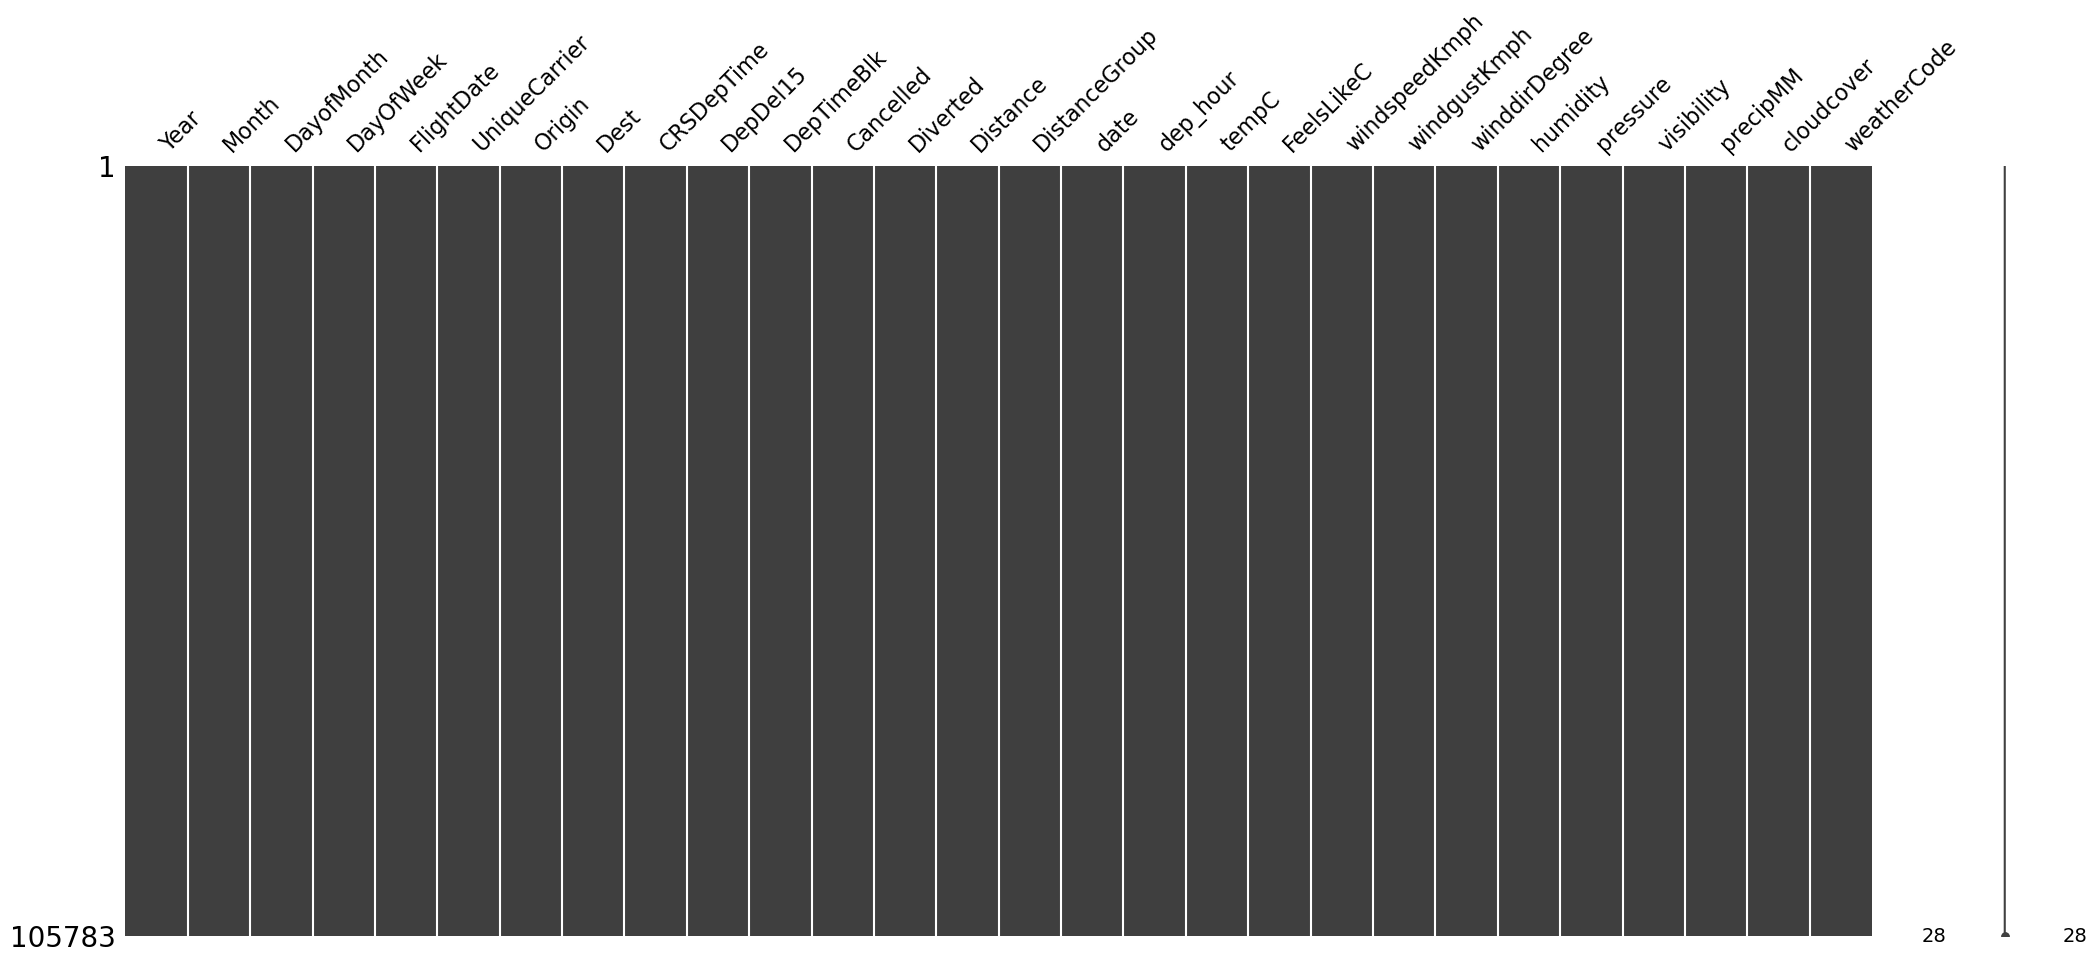

In [11]:
#Missing-value check after merge
flight_weather.isna().mean().sort_values(ascending=False).head(10)


print(msno.matrix(flight_weather))

Flight data was successfully merged with hourly weather data using origin airport, date, and scheduled departure hour, resulting in complete weather coverage for all flights.

#### Final cleanup and save merged dataset

- Dropping FlightDate, date columns since The columns Year, Month and DayofMonth give this information in separate columns and are redundant
- Ensure datatypes are consistent
- Save final dataset to csv file

In [12]:
# Remove redundant date columns after merging to clean up the dataset
flight_weather = flight_weather.drop(columns=["FlightDate", "date"])

In [13]:
# Convert selected columns to integer type for better data handling
flight_weather[["DepDel15", "Cancelled", "Diverted"]] = flight_weather[["DepDel15", "Cancelled", "Diverted"]].astype(int)


#### Final quick integrity checks

In [14]:
# Display the dimensions of the final merged dataframe
print("Final shape:", flight_weather.shape)

# Check for the total count of missing values across all columns
print("Any missing values:", flight_weather.isna().sum().sum())


flight_weather.info()
flight_weather.head()

Final shape: (105783, 26)
Any missing values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105783 entries, 0 to 105782
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           105783 non-null  int64  
 1   Month          105783 non-null  int64  
 2   DayofMonth     105783 non-null  int64  
 3   DayOfWeek      105783 non-null  int64  
 4   UniqueCarrier  105783 non-null  object 
 5   Origin         105783 non-null  object 
 6   Dest           105783 non-null  object 
 7   CRSDepTime     105783 non-null  int64  
 8   DepDel15       105783 non-null  int64  
 9   DepTimeBlk     105783 non-null  object 
 10  Cancelled      105783 non-null  int64  
 11  Diverted       105783 non-null  int64  
 12  Distance       105783 non-null  float64
 13  DistanceGroup  105783 non-null  int64  
 14  dep_hour       105783 non-null  Int64  
 15  tempC          105783 non-null  int64  
 16  FeelsLikeC     105783 non-

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,...,FeelsLikeC,windspeedKmph,windgustKmph,winddirDegree,humidity,pressure,visibility,precipMM,cloudcover,weatherCode
0,2016,1,1,5,AA,SEA,JFK,745,0,0700-0759,...,-1,7,8,107,66,1030,10,0.0,0,113
1,2016,1,2,6,AA,SEA,JFK,745,0,0700-0759,...,0,7,8,119,64,1024,10,0.0,0,113
2,2016,1,3,7,AA,SEA,JFK,745,0,0700-0759,...,-3,6,7,85,62,1018,10,0.0,0,113
3,2016,1,4,1,AA,SEA,JFK,745,0,0700-0759,...,-1,5,8,9,95,1010,3,0.2,97,143
4,2016,1,5,2,AA,SEA,JFK,710,0,0700-0759,...,2,5,10,62,91,1001,6,0.1,100,266


#### Save final merged dataset


In [15]:
# Save the merged flight and weather data to a CSV file without the index
flight_weather.to_csv("Data/flight_weather_data.csv", index=False)

### Summary
The processed flight and hourly weather datasets were merged using origin airport, flight date, and scheduled departure hour. The merge preserved all flight records and resulted in complete weather coverage with no missing values. Redundant columns were removed, data types were standardized, and the final dataset was saved for modeling.